## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#force to use cpu(by changing device_count in the tf.ContigProto)
import tensorflow as tf
from keras import backend as K
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0}
                       )

session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# write function to build model
def build_mlp(input_shape,output_units=10,num_neurons=[512,128,64]):
    """
    build your own model
    """
    model=Sequential()
    model.add(Dense(units=input_shape[1], input_dim=input_shape[1],kernel_initializer='normal',activation='relu',name='input'))
    model.add(BatchNormalization()) 
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units,kernel_initializer='normal',activation='relu',name='hidden'+str(i+1)))
        model.add(BatchNormalization()) 
    model.add(Dense(units=output_units,kernel_initializer='normal',activation='softmax',name='output'))
    return model

In [11]:
# write function to plot results
def plot_results(results):
    color_bar=['dodgerblue','greenyellow','red','sienna','lime','green','aqua','maroon','mediumblue','slateblue','darkorchid','purple']
    """
    Draw the results
    """
    plt.figure(figsize=(12,9))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', label='train-'+cond, color=color_bar[i%12])
        plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'],'--', label='valid-'+cond, color=color_bar[i%12])
        plt.hlines(y=loadback_loss, xmin=0, xmax=len(train_loss), colors='r', linestyles='--', label='loadback-'+cond)
    plt.title('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show

    plt.figure(figsize=(12,9))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', label='train-'+cond, color=color_bar[i%12])
        plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'],'--', label='valid-'+cond, color=color_bar[i%12])
        plt.hlines(y=loadback_acc, xmin=0, xmax=len(train_acc), colors='r', linestyles='--', label='loadback-'+cond)
    plt.title('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE=1e-3
EPOCHS=30
BATCH_SIZE=256
MOMENTUM=0.9

## 作業一、試比較 save_best_only 與否的差異

In [8]:
"""
Write your training loop and show the results
"""
results_D86_hw1={}
for ckpt_best_only in ['yes','no']:
    model=build_mlp(input_shape=x_train.shape)
    model.summary()
    optimizer=SGD(lr=LEARNING_RATE,nesterov=True, momentum=MOMENTUM)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    if ckpt_best_only=='yes':
        model_ckpt=ModelCheckpoint(filepath='D86HW1.h5',
                                   monitor='val_loss',
                                   save_best_only=True)
        model.fit(x_train,y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test,y_test),
                  shuffle=True,
                  callbacks=[model_ckpt])
        
    elif ckpt_best_only=='no':
        model_ckpt=ModelCheckpoint(filepath='D86HW1.h5',
                                   monitor='val_loss',
                                   save_best_only=False)
        model.fit(x_train,y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test,y_test),
                  shuffle=True,
                  callbacks=[model_ckpt])
       
    # collect results
    train_loss=model.history.history['loss']
    valid_loss=model.history.history['val_loss']
    train_acc=model.history.history['acc']
    valid_acc=model.history.history['val_acc']
    
    #loadback model
    model_back = keras.models.load_model("D86HW1.h5")
    loadback_loss, loadback_acc = model_back.evaluate(x_test, y_test)
    
    # construct dictionary
    exp_name_tag = f"save_best_only is {str(ckpt_best_only)}"
        
    results_D86_hw1[exp_name_tag]={'train_loss':train_loss,
                                   'valid_loss':valid_loss,
                                   'train_acc':train_acc,
                                   'valid_acc':valid_acc,
                                   'loadback_loss':loadback_loss,
                                   'loadback_acc':loadback_acc
                                  }
        

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden2 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
hidd

50000/50000 [==============================] - 40s 799us/step - loss: 1.8140 - acc: 0.3586 - val_loss: 1.7538 - val_acc: 0.3813
Epoch 3/30
50000/50000 [==============================] - 40s 793us/step - loss: 1.6911 - acc: 0.4015 - val_loss: 1.6741 - val_acc: 0.4064
Epoch 4/30
50000/50000 [==============================] - 42s 836us/step - loss: 1.6067 - acc: 0.4302 - val_loss: 1.6210 - val_acc: 0.4182
Epoch 5/30
50000/50000 [==============================] - 40s 799us/step - loss: 1.5404 - acc: 0.4554 - val_loss: 1.5844 - val_acc: 0.4337
Epoch 6/30
50000/50000 [==============================] - 39s 776us/step - loss: 1.4852 - acc: 0.4750 - val_loss: 1.5564 - val_acc: 0.4454
Epoch 7/30
50000/50000 [==============================] - 39s 773us/step - loss: 1.4348 - acc: 0.4927 - val_loss: 1.5313 - val_acc: 0.4538
Epoch 8/30
50000/50000 [==============================] - 40s 802us/step - loss: 1.3906 - acc: 0.5082 - val_loss: 1.5162 - val_acc: 0.4576
Epoch 9/30
50000/50000 [==============

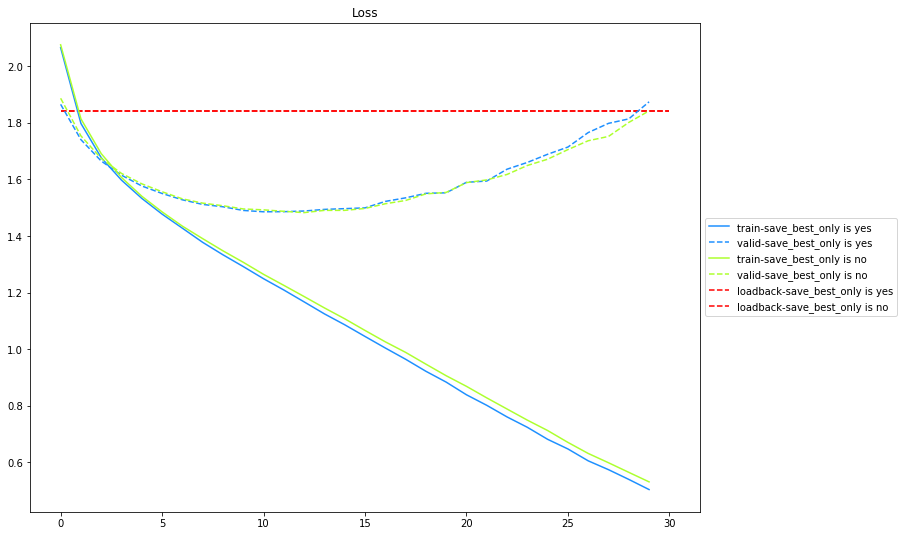

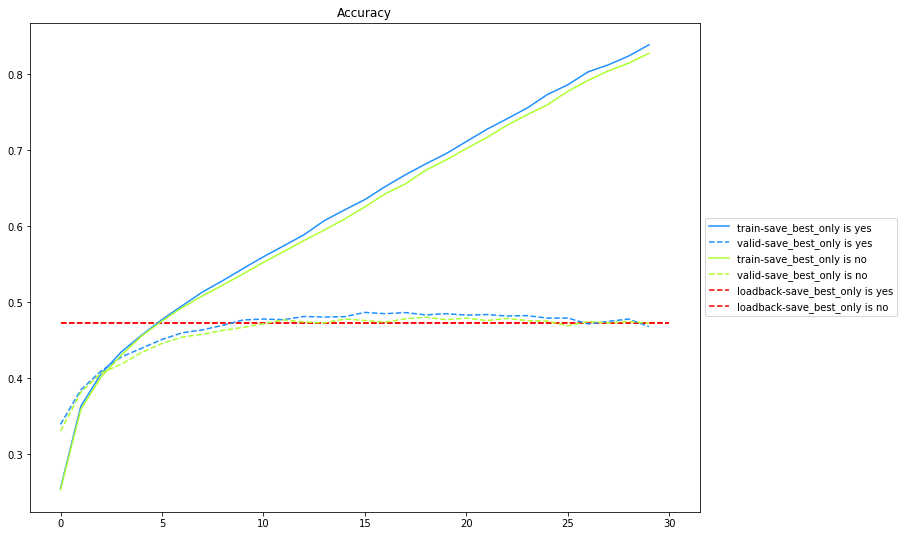

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_results(results_D86_hw1)

## 作業二、請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [13]:
results_D86_hw2={}

model=build_mlp(input_shape=x_train.shape)
model.summary()
optimizer=SGD(lr=LEARNING_RATE,nesterov=True, momentum=MOMENTUM)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model_ckpt=ModelCheckpoint(filepath='D86HW2.h5',
                           monitor='val_loss',
                           save_best_only=False,
                           save_weights_only=True)
model.fit(x_train,y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test,y_test),
          shuffle=True,
          callbacks=[model_ckpt])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
batch_normalization_9 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden2 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
hidden3 (Dense)              (None, 64)                8256      
__________

In [17]:
keras.backend.clear_session()
#create new model
model_back2 = build_mlp(input_shape=x_train.shape)

#load back weights of model
model_back2.summary()
model_back2.load_weights("D86HW2.h5")

model_back2.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

#evaluate model_back2
loss_loadback, acc_loadback = model_back2.evaluate(x_test, y_test)
print(f'Loss: {loss_loadback}, Acccuracy: {acc_loadback}')

#predict x_test
y_predict_model_back2=model_back2.predict(x_test)
for i in range(len(x_test)):
    print(f"X= {x_test[i]} , Predicted = {y_predict_model_back2[i]}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden2 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
hidden3 (Dense)              (None, 64)                8256      
__________

 0.00406217 0.00053508 0.00112882 0.02693597]
X= [0.27843137 0.27058824 0.30980392 ... 0.14901961 0.14509804 0.16862745] , Predicted = [1.4074500e-05 2.5761610e-05 3.9211981e-04 6.4773273e-01 9.7597025e-05
 3.3888942e-01 1.2136328e-02 5.0643271e-06 6.9956499e-04 7.2390676e-06]
X= [0.05882353 0.0627451  0.0745098  ... 0.07058824 0.0745098  0.0627451 ] , Predicted = [3.9483136e-03 1.8587753e-02 4.7771132e-04 5.9665932e-04 1.1111963e-04
 1.2021103e-02 4.1515406e-04 4.2715278e-03 1.5260485e-03 9.5804459e-01]
X= [0.44313725 0.44705882 0.47058824 ... 0.44313725 0.45098039 0.4745098 ] , Predicted = [0.00479339 0.00050356 0.01358384 0.41760084 0.00976928 0.33957177
 0.02092759 0.18914841 0.00279039 0.0013109 ]
X= [0.78431373 0.70588235 0.64705882 ... 0.14901961 0.13333333 0.21568627] , Predicted = [0.00350133 0.06567159 0.01415052 0.47859213 0.00946204 0.06810383
 0.34972483 0.00070138 0.00092252 0.00916967]
X= [0.78039216 0.71372549 0.67058824 ... 0.65490196 0.60784314 0.55294118] , Predicted

 1.5407075e-03 6.4642839e-02 6.4859621e-04 3.1423256e-01 3.1554154e-03]
X= [0.36470588 0.36470588 0.36078431 ... 0.88235294 0.72941176 0.49411765] , Predicted = [5.2043743e-04 1.9422259e-05 7.0109032e-02 4.7084196e-03 8.8647467e-01
 5.1413658e-03 1.9844589e-03 3.0913124e-02 7.3064199e-05 5.6022614e-05]
X= [0.90980392 0.90980392 0.90980392 ... 0.4627451  0.4627451  0.4627451 ] , Predicted = [0.08526632 0.00285756 0.02077288 0.01295237 0.00582364 0.01160411
 0.07570598 0.00347368 0.7803701  0.00117339]
X= [0.34509804 0.3372549  0.35686275 ... 0.44313725 0.39607843 0.37254902] , Predicted = [8.8342080e-05 7.8435060e-06 6.5449417e-01 2.0835488e-01 3.3188138e-02
 6.9822744e-02 1.1396540e-03 3.2848235e-02 4.2498727e-06 5.1719868e-05]
X= [0.21176471 0.27058824 0.18823529 ... 0.51764706 0.63529412 0.36078431] , Predicted = [3.9479750e-05 3.9341365e-05 2.3989371e-04 1.1499825e-04 1.1734739e-01
 1.3125449e-02 4.6979501e-05 8.6893535e-01 1.5008951e-05 9.6145312e-05]
X= [0.5372549  0.47058824 0.38

X= [0.49803922 0.6        0.70588235 ... 0.47058824 0.43137255 0.40784314] , Predicted = [9.1567862e-01 1.4002562e-02 2.4518727e-03 2.1279404e-04 7.3774769e-03
 7.5248501e-04 4.1283591e-04 2.7622012e-03 5.2601833e-02 3.7471384e-03]
X= [0.94509804 0.95686275 0.98431373 ... 0.23921569 0.20784314 0.1372549 ] , Predicted = [2.8017409e-02 8.3608483e-04 8.0222897e-05 1.3496782e-04 5.4037763e-04
 4.2433356e-05 1.4682052e-05 4.6256536e-01 4.9327151e-03 5.0283569e-01]
X= [0.81176471 0.83137255 0.81176471 ... 0.81960784 0.83137255 0.75686275] , Predicted = [4.5064944e-03 8.0970985e-01 2.8268009e-04 6.9094572e-04 3.1397787e-05
 3.0927404e-05 1.1471736e-02 1.9112504e-04 2.3805867e-03 1.7070438e-01]
X= [0.21960784 0.20784314 0.19215686 ... 0.14117647 0.14901961 0.14509804] , Predicted = [5.5705025e-03 3.7311285e-03 3.0601569e-02 4.5045678e-02 3.7767150e-02
 4.5731505e-03 8.6508077e-01 8.3611300e-04 6.3249264e-03 4.6899630e-04]
X= [0.21568627 0.03137255 0.01960784 ... 0.54117647 0.39607843 0.2156862

 1.7020770e-03 9.3460816e-01 4.9470383e-04 1.8685897e-03 1.3161265e-02]
X= [0.61568627 0.6745098  0.65882353 ... 0.44705882 0.4627451  0.49803922] , Predicted = [0.01109831 0.05334973 0.06868402 0.01432867 0.03757041 0.05739376
 0.01576915 0.0868625  0.22606198 0.42888144]
X= [0.03529412 0.03529412 0.03529412 ... 0.5372549  0.34117647 0.34117647] , Predicted = [1.2634292e-03 7.4654734e-01 1.5774261e-03 7.5612105e-03 7.5947074e-04
 2.0108267e-03 1.3642628e-03 3.7379729e-04 8.8804001e-03 2.2966172e-01]
X= [0.01960784 0.01568627 0.03529412 ... 0.05098039 0.04705882 0.07843137] , Predicted = [1.39009557e-04 8.59791995e-04 8.76757374e-04 7.15871065e-05
 2.54038678e-05 1.07733114e-03 1.01399055e-05 9.61917341e-01
 4.86099947e-04 3.45364958e-02]
X= [0.4745098  0.55686275 0.7254902  ... 0.58431373 0.66666667 0.83921569] , Predicted = [3.2706207e-01 3.1902728e-04 6.1309987e-01 1.2833843e-02 1.4215899e-03
 1.0439304e-02 2.7528524e-02 1.3956829e-03 5.6061773e-03 2.9387197e-04]
X= [0.45490196 0.53

 3.2178119e-03 7.0353575e-02 7.4457522e-03 3.6509751e-04 4.4146355e-04]
X= [0.48627451 0.62352941 0.29019608 ... 0.53333333 0.65490196 0.39215686] , Predicted = [1.0796102e-03 4.5183559e-05 2.2508180e-01 1.8239820e-02 1.2378690e-02
 7.0319116e-01 1.4336631e-04 3.9427463e-02 6.0595106e-05 3.5232728e-04]
X= [0.25098039 0.19215686 0.07058824 ... 0.55686275 0.47843137 0.14509804] , Predicted = [5.8817177e-04 3.6083682e-05 8.9677274e-03 2.2783189e-03 9.7311926e-01
 5.9728825e-04 1.2151828e-02 1.8138686e-03 3.7238351e-04 7.5112315e-05]
X= [0.49019608 0.36078431 0.16470588 ... 0.30196078 0.20784314 0.1254902 ] , Predicted = [6.7111501e-03 1.8237761e-04 4.7350585e-01 8.6711692e-03 3.3243158e-01
 3.8651284e-03 1.7352599e-01 3.4388559e-04 6.9101964e-04 7.1857270e-05]
X= [0.68235294 0.7372549  0.9254902  ... 0.83529412 0.8745098  0.97254902] , Predicted = [0.8042228  0.0124913  0.13960564 0.00672679 0.00520513 0.00691743
 0.00100872 0.00116308 0.01637815 0.00628078]
X= [1.         1.         1.  

 0.00433484 0.07349374 0.04641183 0.04158931]
X= [0.29803922 0.2627451  0.28235294 ... 0.47843137 0.43921569 0.49019608] , Predicted = [3.7523787e-03 2.4939640e-04 4.8684492e-03 4.7008675e-01 6.5392861e-03
 5.0629079e-01 4.3444601e-03 9.5969363e-04 2.5390966e-03 3.6974158e-04]
X= [0.23529412 0.22745098 0.20392157 ... 0.56862745 0.46666667 0.39215686] , Predicted = [0.01788367 0.69670296 0.00693552 0.03800691 0.00450942 0.04715404
 0.017494   0.01181473 0.07657975 0.08291909]
X= [0.85490196 0.8745098  0.90980392 ... 0.83529412 0.79215686 0.74901961] , Predicted = [2.7603770e-02 2.5604260e-01 1.6887832e-02 4.4556926e-03 1.6211851e-01
 6.2163770e-03 3.3222893e-01 1.9425340e-04 1.9219199e-01 2.0600823e-03]
X= [0.32941176 0.38039216 0.4        ... 0.19215686 0.15686275 0.12941176] , Predicted = [0.14668666 0.00209975 0.24259962 0.03017067 0.32508728 0.10499799
 0.02231383 0.02424513 0.08859184 0.01320726]
X= [0.32941176 0.29019608 0.28235294 ... 0.33333333 0.29803922 0.27058824] , Predicted

 0.50571036 0.00077561 0.00118182 0.00102677]
X= [0.36078431 0.30196078 0.28235294 ... 0.32941176 0.29019608 0.28627451] , Predicted = [1.43896559e-05 1.02222664e-04 1.15036312e-03 3.05054076e-02
 3.02529312e-04 9.63643491e-01 1.70601634e-05 2.58198846e-03
 1.50064821e-04 1.53254322e-03]
X= [0.45490196 0.43137255 0.29019608 ... 0.38039216 0.38039216 0.30980392] , Predicted = [1.2131628e-03 1.1668113e-05 2.4553587e-01 4.0333593e-04 7.4772882e-01
 7.1120783e-05 4.0372964e-03 9.4582408e-04 4.8545418e-05 4.3089753e-06]
X= [0.42352941 0.48627451 0.2627451  ... 0.31764706 0.39607843 0.1254902 ] , Predicted = [1.2941528e-03 1.7069919e-04 3.3062674e-02 2.8452370e-02 2.2682569e-03
 3.1465009e-02 8.6088729e-01 3.7726287e-02 9.7771102e-05 4.5755138e-03]
X= [0.56078431 0.65098039 0.85490196 ... 0.71764706 0.70980392 0.65490196] , Predicted = [3.8462806e-02 3.7955990e-01 1.0064387e-03 2.9051077e-04 1.5569502e-03
 9.0394293e-05 2.7849618e-04 1.1536033e-04 4.1477594e-01 1.6386314e-01]
X= [0.68627451 

 1.4956485e-04 1.1654600e-04 1.6555439e-03 1.1576053e-02 9.5713817e-02]
X= [0.90980392 0.90588235 0.92156863 ... 0.6745098  0.64705882 0.63921569] , Predicted = [1.1427004e-01 3.4408376e-01 1.0090162e-04 2.7035025e-04 3.7717581e-04
 1.9263061e-04 3.1314840e-04 2.3751028e-03 3.1022159e-02 5.0699478e-01]
X= [1.         1.         1.         ... 0.65882353 0.7372549  0.6627451 ] , Predicted = [6.9962276e-05 1.2239239e-05 1.0121746e-04 1.3934342e-03 3.0494624e-04
 3.0924937e-02 2.2682752e-05 9.6659607e-01 3.9569342e-05 5.3500722e-04]
X= [0.69803922 0.75294118 0.80392157 ... 0.48235294 0.35294118 0.27843137] , Predicted = [9.7286564e-01 2.7962643e-04 4.8331940e-03 6.9684887e-05 2.0338975e-02
 2.0040492e-04 5.7098514e-05 2.2416007e-04 9.8164391e-04 1.4956151e-04]
X= [0.07843137 0.14509804 0.05490196 ... 0.48627451 0.45882353 0.39607843] , Predicted = [0.02126957 0.03690841 0.3409812  0.01895099 0.20168065 0.28349188
 0.00709807 0.04504234 0.03463958 0.00993723]
X= [0.48627451 0.29411765 0.25

 5.4790997e-03 4.4496450e-01 1.4142539e-05 4.5944285e-03 1.7016182e-04]
X= [0.65490196 0.50588235 0.39607843 ... 0.72941176 0.67058824 0.58039216] , Predicted = [9.29072127e-02 6.09163582e-01 1.32040726e-02 3.42960004e-04
 6.59958678e-05 1.53567453e-05 1.07102674e-02 1.39372105e-05
 4.08775778e-03 2.69488841e-01]
X= [0.59215686 0.62745098 0.6627451  ... 0.47843137 0.47843137 0.43921569] , Predicted = [9.3372679e-01 1.7993624e-04 7.2795972e-03 5.6919547e-05 1.7408224e-02
 1.3779833e-04 5.4483116e-05 3.3466920e-02 7.0686629e-03 6.2069751e-04]
X= [0.97647059 1.         1.         ... 0.89411765 0.72941176 0.60784314] , Predicted = [1.0607175e-01 8.6379313e-01 3.7865291e-04 2.8109378e-03 6.6461395e-03
 1.6171141e-03 6.1191729e-04 7.5213547e-04 1.8525105e-03 1.5465777e-02]
X= [0.7372549  0.57647059 0.42352941 ... 0.50588235 0.34901961 0.19215686] , Predicted = [8.4615295e-04 1.6251366e-03 3.4829877e-02 6.7084804e-02 2.1080188e-02
 3.7762073e-01 1.6611113e-01 3.2552460e-01 3.5401774e-04 4.92

 0.05831216 0.1341307  0.0013952  0.04621134]
X= [0.42352941 0.39215686 0.38431373 ... 0.54901961 0.56078431 0.56078431] , Predicted = [6.1693642e-04 5.3133662e-03 2.4464361e-03 3.0339565e-04 1.9022621e-02
 4.0366082e-03 3.5442310e-04 9.4374174e-01 1.8000077e-04 2.3984447e-02]
X= [0.62352941 0.66666667 0.62745098 ... 0.6627451  0.69019608 0.64705882] , Predicted = [0.2136591  0.29067764 0.04271242 0.1729729  0.06824978 0.00323792
 0.02059953 0.01797562 0.07174863 0.09816656]
X= [0.62745098 0.73333333 0.54901961 ... 0.55686275 0.5254902  0.51764706] , Predicted = [2.0218005e-03 9.3622220e-06 9.6575379e-01 4.7215573e-03 1.1858814e-02
 5.3737196e-03 9.8988097e-03 7.8347672e-05 2.5926522e-04 2.4234940e-05]
X= [0.57647059 0.70980392 0.89411765 ... 0.10588235 0.11372549 0.08235294] , Predicted = [0.10244846 0.04866625 0.02647135 0.00685499 0.00618046 0.00116554
 0.0022729  0.00541539 0.74458694 0.05593767]
X= [0.39607843 0.4627451  0.27843137 ... 0.34901961 0.28627451 0.25098039] , Predicted

 2.4160591e-04 5.8121672e-03 1.4017097e-04 2.1407703e-02 1.7417729e-04]
X= [0.10980392 0.1254902  0.16862745 ... 0.34117647 0.21568627 0.23529412] , Predicted = [7.8498588e-06 2.8976461e-05 5.2967982e-04 8.7904072e-01 8.7365676e-03
 3.4488190e-02 7.6822206e-02 8.8952675e-06 3.2657673e-04 1.0376310e-05]
X= [0.99607843 1.         1.         ... 0.81176471 0.82352941 0.84313725] , Predicted = [0.8554841  0.02839615 0.00267205 0.00539956 0.00586232 0.00267876
 0.00126908 0.00091574 0.09381624 0.00350594]
X= [0.33333333 0.41960784 0.20784314 ... 0.37254902 0.27058824 0.27058824] , Predicted = [4.3425817e-04 1.1611440e-04 6.8675070e-03 1.5958206e-01 2.2618914e-02
 7.7069521e-01 3.2946445e-02 5.0156070e-03 6.9340703e-04 1.0305553e-03]
X= [0.51372549 0.7254902  0.90980392 ... 0.78823529 0.84705882 0.90980392] , Predicted = [9.0300834e-01 1.4155544e-02 5.5237702e-04 5.7278176e-05 1.3901172e-04
 1.9380162e-05 2.2667757e-05 4.3810363e-05 7.7948853e-02 4.0527317e-03]
X= [0.90980392 0.90980392 0.91

 0.35235572 0.00893986 0.00310073 0.00103214]
X= [0.61960784 0.70196078 0.73333333 ... 0.15686275 0.10980392 0.05098039] , Predicted = [7.8809902e-02 5.4186727e-05 1.4701598e-02 1.1917205e-02 1.7886015e-02
 6.4825295e-03 5.2128591e-02 1.5075634e-02 8.0191934e-01 1.0250235e-03]
X= [0.61960784 0.78823529 0.95294118 ... 0.67843137 0.64313725 0.61568627] , Predicted = [4.97902511e-04 1.24312683e-05 3.03200097e-03 8.85293775e-05
 6.40700385e-03 6.15748228e-04 1.15273015e-05 9.89056885e-01
 6.73291379e-06 2.71206954e-04]
X= [0.40392157 0.36862745 0.29411765 ... 0.45098039 0.39215686 0.30196078] , Predicted = [2.8570154e-04 2.7441289e-05 3.4457287e-01 3.6174155e-04 1.6334005e-01
 3.6212365e-04 4.9090302e-01 9.4644238e-05 4.2147305e-05 1.0136888e-05]
X= [0.60392157 0.55294118 0.52156863 ... 0.48627451 0.48627451 0.28627451] , Predicted = [3.3392513e-03 1.7491035e-04 3.0792145e-02 6.7404826e-04 8.9928454e-01
 1.0117110e-03 5.3926562e-03 5.7532746e-02 5.7521363e-04 1.2227894e-03]
X= [0.6745098  

 0.05589003 0.02630384 0.02083305 0.02529338]
X= [0.4627451  0.41568627 0.5254902  ... 0.54901961 0.45490196 0.52156863] , Predicted = [5.3355101e-02 6.0020253e-04 6.7766353e-02 9.9874549e-02 5.6630813e-02
 6.6202134e-01 1.7867800e-02 2.3263842e-02 1.5239234e-02 3.3807145e-03]
X= [0.50980392 0.50980392 0.50980392 ... 0.16078431 0.14901961 0.11764706] , Predicted = [2.4239086e-03 9.2098329e-05 3.4423152e-01 3.8749322e-01 1.2965557e-01
 1.1289417e-01 3.1806348e-04 1.9670939e-02 3.1768591e-03 4.3664819e-05]
X= [0.09019608 0.21568627 0.15686275 ... 0.02352941 0.02745098 0.01960784] , Predicted = [0.00216791 0.18075217 0.00682945 0.0699508  0.0021188  0.00260616
 0.24655272 0.00080487 0.00060796 0.48760918]
X= [0.31372549 0.36078431 0.38039216 ... 0.07843137 0.09803922 0.11764706] , Predicted = [9.30709764e-04 1.15451805e-01 8.44894268e-04 1.23019353e-03
 2.08354206e-04 1.27253169e-02 1.91455765e-03 9.94109921e-03
 6.84761703e-02 7.88276911e-01]
X= [1.         1.         0.92941176 ... 0.60

 7.47316381e-06 3.44756836e-06]
X= [0.09803922 0.10196078 0.09803922 ... 0.21568627 0.29803922 0.06666667] , Predicted = [0.00066208 0.00217219 0.21718717 0.3210204  0.20897949 0.07271645
 0.00239803 0.15557949 0.00175791 0.01752686]
X= [0.29803922 0.26666667 0.21568627 ... 0.64313725 0.61568627 0.54117647] , Predicted = [1.8615670e-05 2.5064114e-04 2.5147157e-02 2.6102948e-01 6.9839070e-03
 5.5323470e-01 1.4365429e-01 3.6313842e-04 3.2829077e-04 8.9897942e-03]
X= [0.20784314 0.21176471 0.1372549  ... 0.70980392 0.67843137 0.35294118] , Predicted = [8.1536797e-04 1.6700001e-03 5.4323687e-03 1.4322377e-02 4.4834790e-01
 5.7342488e-02 8.1994019e-02 3.8808224e-01 2.6712436e-04 1.7261398e-03]
X= [0.95686275 1.         1.         ... 0.17647059 0.18039216 0.15686275] , Predicted = [2.2250237e-05 1.1189723e-03 9.2834107e-06 2.1581140e-05 1.2697350e-06
 3.7113798e-06 1.2352433e-06 5.0684210e-04 3.7900107e-05 9.9827695e-01]
X= [0.26666667 0.2745098  0.29019608 ... 0.43921569 0.51372549 0.69803

 6.2144017e-03 1.0637114e-04 2.9085547e-01 7.0097984e-04 1.2122476e-03]
X= [0.25098039 0.30588235 0.34509804 ... 0.16470588 0.17647059 0.15294118] , Predicted = [4.3789321e-03 3.3350970e-04 3.8367566e-01 2.4080144e-02 5.0699663e-01
 1.9597333e-02 3.1772438e-02 2.0407135e-02 3.7293974e-03 5.0287889e-03]
X= [0.17254902 0.34901961 0.36078431 ... 0.5254902  0.48627451 0.39215686] , Predicted = [0.30985326 0.12001415 0.0234521  0.00286378 0.18354352 0.00486036
 0.01149236 0.00374458 0.12642407 0.21375187]
X= [0.65490196 0.69803922 0.82352941 ... 0.21960784 0.2627451  0.23529412] , Predicted = [1.70514718e-01 9.14233155e-04 4.98347916e-02 2.56306812e-04
 2.94313114e-02 4.83558746e-04 4.21474717e-04 5.13996603e-03
 7.27515936e-01 1.54876355e-02]
X= [0.56078431 0.41176471 0.21176471 ... 0.07058824 0.01568627 0.01568627] , Predicted = [0.15268914 0.01371286 0.00171383 0.42264524 0.00863816 0.16193275
 0.00561384 0.06893496 0.12421875 0.0399005 ]
X= [0.16470588 0.27058824 0.21568627 ... 0.050980

 0.00296723 0.5856217  0.00615666 0.21827915]
X= [0.62352941 0.70980392 0.98431373 ... 0.22745098 0.3254902  0.6627451 ] , Predicted = [1.14892729e-01 1.65089709e-03 5.25622803e-04 3.08469782e-04
 1.14215276e-04 9.64432023e-04 2.70498276e-04 1.45592057e-04
 8.80861878e-01 2.65715033e-04]
X= [0.02352941 0.02352941 0.02352941 ... 0.19607843 0.20784314 0.20392157] , Predicted = [3.47287965e-07 9.99996424e-01 1.08581104e-11 1.43893526e-11
 4.87144977e-11 1.32214222e-11 1.03953945e-09 3.75675428e-11
 1.75086029e-06 1.48999709e-06]
X= [0.83137255 0.94117647 0.92156863 ... 0.35686275 0.28235294 0.28627451] , Predicted = [0.00887385 0.0816694  0.01523018 0.0546537  0.00722882 0.03323798
 0.06007879 0.01138157 0.00389232 0.72375345]
X= [0.71372549 0.74117647 0.70588235 ... 0.98823529 0.98823529 0.96470588] , Predicted = [1.6673872e-06 9.6109716e-07 9.0244976e-05 3.3164179e-05 3.1835862e-04
 3.5723960e-03 2.6666557e-06 9.9595499e-01 1.2983462e-07 2.5427446e-05]
X= [0.00784314 0.00392157 0.003921

 1.8349858e-05 5.6111272e-05 2.5429081e-03 4.6404649e-02 7.8569837e-02]
X= [0.56470588 0.5254902  0.37254902 ... 0.45490196 0.49411765 0.5254902 ] , Predicted = [9.8224718e-04 8.3651137e-01 1.1066111e-04 1.3523641e-04 5.3162206e-05
 2.6374299e-04 2.4356743e-04 1.1584119e-04 1.5388051e-01 7.7035702e-03]
X= [0.97254902 0.98039216 0.97254902 ... 0.54117647 0.44313725 0.34901961] , Predicted = [1.6824162e-05 7.2334398e-05 1.4246911e-03 8.2392114e-01 1.5590776e-05
 1.7029446e-01 3.2242760e-03 3.6623147e-05 2.9566912e-05 9.6455839e-04]
X= [0.94117647 0.96078431 0.98039216 ... 0.98039216 0.95686275 0.96470588] , Predicted = [6.53500706e-02 3.64118605e-04 1.55873755e-02 1.47023395e-01
 2.51534069e-03 7.38762081e-01 1.30532747e-02 1.06987301e-02
 5.00003458e-04 6.14560675e-03]
X= [0.10588235 0.18039216 0.34509804 ... 0.76862745 0.7254902  0.7254902 ] , Predicted = [7.5245165e-04 6.9069564e-01 6.8138099e-05 7.9151338e-05 1.5483924e-05
 1.7592407e-04 2.0464965e-04 1.8564167e-02 2.6715617e-03 2.86

 2.9431048e-06 6.0109637e-04 7.4668485e-04 4.7761840e-03 7.5138384e-01]
X= [0.25098039 0.5254902  0.41176471 ... 0.23137255 0.36862745 0.34901961] , Predicted = [5.40380461e-06 9.87850368e-01 4.62266740e-07 2.51064175e-05
 3.71965530e-06 1.35969185e-05 3.43874635e-05 7.64542256e-06
 6.83236541e-03 5.22696879e-03]
X= [0.24705882 0.21176471 0.12156863 ... 0.34117647 0.43921569 0.41960784] , Predicted = [5.86433725e-06 9.97689366e-01 3.26492142e-07 1.05043617e-03
 1.99432819e-07 1.20008597e-04 5.52324753e-04 6.26660540e-06
 1.05984116e-04 4.69237188e-04]
X= [0.45490196 0.29803922 0.05882353 ... 0.56470588 0.36470588 0.08235294] , Predicted = [0.03865272 0.02740552 0.05684451 0.36671314 0.02064203 0.3127335
 0.15559046 0.00158928 0.00210783 0.01772104]
X= [0.78823529 0.80392157 0.82745098 ... 0.99215686 0.99215686 0.99215686] , Predicted = [8.4808851e-03 2.1755753e-01 8.0739084e-04 1.7618622e-03 4.0907349e-04
 5.7297043e-04 1.5516111e-03 3.0779597e-04 2.0441074e-02 7.4810982e-01]
X= [0.741

 1.5053445e-02 1.5700266e-03 8.6761028e-01 9.5071031e-05 1.5706675e-04]
X= [0.05882353 0.13333333 0.1254902  ... 0.56470588 0.73333333 0.63529412] , Predicted = [4.0663261e-04 6.4069514e-05 1.7773895e-02 4.8363893e-04 8.9835018e-01
 1.8355743e-03 3.4672983e-05 8.0726601e-02 2.3019219e-04 9.4659714e-05]
X= [0.29803922 0.48627451 0.80784314 ... 0.51764706 0.53333333 0.58823529] , Predicted = [8.7223631e-01 4.1276365e-04 1.3443796e-03 3.3323238e-05 2.0623042e-03
 4.0871375e-05 6.4382475e-05 4.7829071e-05 1.2280202e-01 9.5591845e-04]
X= [0.32156863 0.33333333 0.16862745 ... 0.2745098  0.24313725 0.17254902] , Predicted = [8.0113678e-04 4.3034404e-05 8.1633425e-01 4.0442683e-03 7.2291106e-02
 6.3310523e-04 1.0481089e-01 9.9886861e-04 1.5620402e-05 2.7681343e-05]
X= [1.         0.98039216 1.         ... 0.05882353 0.03921569 0.0627451 ] , Predicted = [0.01383988 0.01567915 0.00661179 0.03771086 0.01343172 0.08239284
 0.01187047 0.7517112  0.0161809  0.05057126]
X= [0.67058824 0.7372549  0.29

 2.3806533e-01 1.3078530e-03 7.2166437e-01 2.2678018e-04 3.3687395e-03]
X= [0.42745098 0.47843137 0.21176471 ... 0.34901961 0.35294118 0.25882353] , Predicted = [7.6099757e-05 7.3702545e-06 6.3159537e-01 1.9999353e-04 3.5916024e-01
 9.9650910e-04 7.5137787e-03 4.3527698e-04 8.0842728e-06 7.3019301e-06]
X= [0.43921569 0.43529412 0.42745098 ... 0.25490196 0.25490196 0.24705882] , Predicted = [9.86666620e-01 1.70531985e-03 2.29309051e-04 1.12483196e-03
 1.12649475e-04 3.41765000e-04 3.50608228e-04 8.28595803e-05
 1.16366881e-03 8.22233129e-03]
X= [0.51764706 0.49019608 0.35686275 ... 0.48235294 0.44313725 0.39607843] , Predicted = [1.5372513e-02 9.4657511e-01 1.1569819e-04 2.1576587e-04 6.0856310e-05
 2.7174558e-05 2.6335960e-04 6.4375294e-05 6.4746221e-04 3.6657803e-02]
X= [0.22745098 0.25490196 0.28235294 ... 0.63921569 0.52941176 0.43529412] , Predicted = [4.5502619e-03 3.0742210e-04 2.5835988e-04 1.4796429e-03 7.4201049e-03
 1.4457488e-04 3.3102564e-03 9.8127568e-01 1.1084450e-03 1.45